In [15]:
import tifffile
import numpy as np
import pandas as pd
import xs3d
import matplotlib.pyplot as plt

In [16]:
# image file path
# os.chdir('/ACdata/Users/wanqing/exaSPIM/exaSPIM_H17.24.006_2023-09-22_14-52-45/exaSPIM/mip2/x2y1z0 tile')
img_file = "/ACdata/Users/wanqing/exaSPIM/forOlga/Result of tile_x_0002_y_0001_z_0000_ch_488_mip2-8bit-zcut.tif"

# skeleton file path
sk_file = r'/ACdata/Users/wanqing/exaSPIM/exaSPIM_H17.24.006_2023-09-22_14-52-45/exaSPIM/mip2/x2y1z0/skeleton/skeletons_10/0002.swc'

In [17]:
# get the tiff info without loading the real data
with tifffile.TiffFile(img_file) as tif:
    img_shape = tif.pages[0].shape
    img_dtype = tif.pages[0].dtype
    
img_shape


(2688, 3584)

In [18]:
# read the sk file
sk = pd.read_csv(sk_file, sep=' ', header=None, comment='#', names=['id', 'type', 'x', 'y', 'z', 'radius', 'parent'])
sk

,id,type,x,y,z,radius,parent
0,1,2,1743.850,1924.85,246.000,3.2480,-1
1,2,2,1736.180,1924.00,249.000,6.4960,1
2,3,2,1727.880,1923.00,252.118,6.4960,2
3,4,2,1720.450,1921.45,255.000,6.4960,3
4,5,2,1713.200,1920.80,257.802,6.4960,4
...,...,...,...,...,...,...,...
144,145,2,900.347,2617.65,337.000,7.2627,144
145,146,2,898.058,2624.94,334.058,6.4960,145
146,147,2,894.571,2632.43,331.000,6.4960,146
147,148,2,891.000,2639.80,328.000,6.4960,147


In [5]:
# can resample the skeleton to different resolution
# but now just go with the current resolution

In [19]:
from tifffile import TiffFile, imsave
import numpy as np

width = 200
img_proj_pp = []
img_proj_vv = []

# Open the image
with TiffFile(img_file) as tif:
    # Convert the image to a 3D numpy array
    img = tif.asarray()

    # Get the first node in the skeleton
    for i, node in sk.loc[1:(len(sk)-2)].iterrows():
        # Use the node's position as the center point
        center_x, center_y, center_z = node['x'], node['y'], node['z']

        # Calculate the start and end points of the cutout
        start_x, end_x = center_x - width // 2, center_x + width // 2
        start_y, end_y = center_y - width // 2, center_y + width // 2
        start_z, end_z = center_z - width // 2, center_z + width // 2

        # Make sure the start and end points are within the image boundaries
        start_x, end_x = int(max(0, start_x)), int(min(img.shape[2], end_x))
        start_y, end_y = int(max(0, start_y)), int(min(img.shape[1], end_y))
        start_z, end_z = int(max(0, start_z)), int(min(img.shape[0], end_z))

        # Extract the cutout
        cutout = img[start_z:end_z, start_y:end_y, start_x:end_x]

        # Get the parent node
        pre_node = sk[sk['id'] == node['parent']]
        next_node = sk[sk['parent'] == node['id']]


        # Subtract the parent node vector from the current node vector
        v = np.array([node.z - next_node.z, node.y - next_node.y, node.x - next_node.x])
        v = v.flatten()
        u = np.array([pre_node.z - node.z, pre_node.y - node.y, pre_node.x - node.x])
        u = u.flatten()
        normal = v / np.linalg.norm(v)
        
        parallel = np.cross(u, v)
        # assuming the first parallel vector is not 0 
        # need to fix this later
        if np.all(parallel == 0):
            parallel = parallel_pre 

        img_proj_v = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), normal, anisotropy=(4, 2.961,2.962), standardize_basis=False)
        img_proj_p = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), parallel, anisotropy=(4, 2.961,2.962), standardize_basis=False)

        parallel_pre = parallel
        
        img_proj_pp.append(img_proj_p)
        img_proj_vv.append(img_proj_v)

    # save the cutout image volume as tif
    # imsave('cutout.tif', cutout)




In [20]:
# Determine the maximum dimensions
max_height = max(img.shape[0] for img in img_proj_pp)
max_width = max(img.shape[1] for img in img_proj_pp)

# Create a new list to hold the padded images
img_proj_pp_padded = []

# Pad each image
for img in img_proj_pp:
    # Determine the padding amounts
    pad_height = max_height - img.shape[0]
    pad_width = max_width - img.shape[1]
    
    # Split the padding amounts evenly between the top/bottom and left/right
    pad_height1, pad_height2 = pad_height // 2, pad_height - pad_height // 2
    pad_width1, pad_width2 = pad_width // 2, pad_width - pad_width // 2
    
    # Pad the image
    img_padded = np.pad(img, ((pad_height1, pad_height2), (pad_width1, pad_width2)))
    
    # Add the padded image to the list
    img_proj_pp_padded.append(img_padded)

# Convert the list back to a numpy array
img_proj_pp_padded = np.array(img_proj_pp_padded)

imsave('img_proj_p.tif', img_proj_pp_padded)

/tmp/ipykernel_3244939/1502744533.py:27: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('img_proj_p.tif', img_proj_pp_padded)


In [21]:
# Determine the maximum dimensions
max_height = max(img.shape[0] for img in img_proj_vv)
max_width = max(img.shape[1] for img in img_proj_vv)

# Create a new list to hold the padded images
img_proj_vv_padded = []

# Pad each image
for img in img_proj_vv:
    # Determine the padding amounts
    pad_height = max_height - img.shape[0]
    pad_width = max_width - img.shape[1]
    
    # Split the padding amounts evenly between the top/bottom and left/right
    pad_height1, pad_height2 = pad_height // 2, pad_height - pad_height // 2
    pad_width1, pad_width2 = pad_width // 2, pad_width - pad_width // 2
    
    # Pad the image
    img_padded = np.pad(img, ((pad_height1, pad_height2), (pad_width1, pad_width2)))
    
    # Add the padded image to the list
    img_proj_vv_padded.append(img_padded)

# Convert the list back to a numpy array
img_proj_vv_padded = np.array(img_proj_vv_padded)

imsave('img_proj_v.tif', img_proj_vv_padded)

/tmp/ipykernel_3244939/2566923096.py:27: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('img_proj_v.tif', img_proj_vv_padded)


In [75]:
 # save the cutout image volume as tif
imsave('cutout.tif', cutout)

/tmp/ipykernel_2250885/2283751380.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('cutout.tif', cutout)


In [127]:
cutout

array([[[24, 23, 25, ..., 29, 28, 30],
        [26, 24, 24, ..., 32, 28, 30],
        [25, 25, 26, ..., 33, 32, 32],
        ...,
        [37, 36, 36, ..., 28, 35, 28],
        [31, 35, 33, ..., 28, 30, 28],
        [25, 26, 28, ..., 25, 26, 25]],

       [[25, 24, 26, ..., 32, 31, 31],
        [24, 22, 24, ..., 38, 32, 31],
        [23, 24, 24, ..., 40, 42, 40],
        ...,
        [42, 36, 33, ..., 29, 31, 25],
        [30, 31, 29, ..., 28, 30, 25],
        [21, 22, 25, ..., 26, 25, 24]],

       [[25, 25, 26, ..., 36, 31, 30],
        [24, 24, 25, ..., 50, 37, 32],
        [23, 23, 24, ..., 54, 54, 45],
        ...,
        [36, 30, 28, ..., 27, 26, 23],
        [23, 24, 24, ..., 27, 27, 24],
        [17, 18, 20, ..., 26, 25, 23]],

       ...,

       [[29, 28, 27, ..., 32, 32, 33],
        [30, 29, 28, ..., 31, 32, 32],
        [30, 30, 29, ..., 30, 31, 31],
        ...,
        [36, 35, 34, ..., 34, 34, 34],
        [35, 35, 35, ..., 36, 36, 34],
        [36, 34, 34, ..., 37, 36

/home/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/wanqing.yu/anaconda3/envs/EM/lib/python3.11/site-packages/I

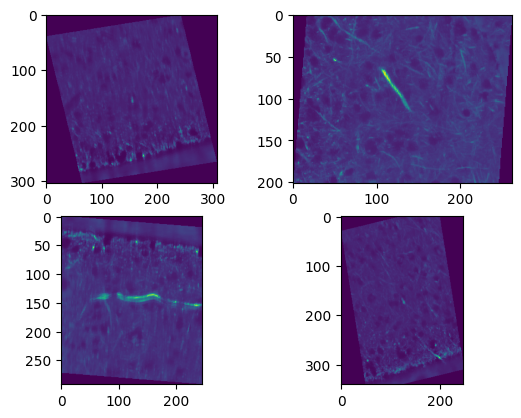

In [144]:
# from tifffile import TiffFile, imsave
# import numpy as np

# width = 200
# img_proj_pp = []
# img_proj_vv = []
# img_proj_pp2 = []
# img_proj_pp3 = []

# # Open the image
# with TiffFile(img_file) as tif:
#     # Convert the image to a 3D numpy array
#     img = tif.asarray()

#     # Get the first node in the skeleton
#     # for i, node in sk.loc[0:(len(sk)-2)].iterrows():
#     node = sk.loc[0]
#     # Use the node's position as the center point
#     center_x, center_y, center_z = node['x'], node['y'], node['z']

#     # Calculate the start and end points of the cutout
#     start_x, end_x = center_x - width // 2, center_x + width // 2
#     start_y, end_y = center_y - width // 2, center_y + width // 2
#     start_z, end_z = center_z - width // 2, center_z + width // 2

#     # Make sure the start and end points are within the image boundaries
#     start_x, end_x = int(max(0, start_x)), int(min(img.shape[2], end_x))
#     start_y, end_y = int(max(0, start_y)), int(min(img.shape[1], end_y))
#     start_z, end_z = int(max(0, start_z)), int(min(img.shape[0], end_z))

#     # Extract the cutout
#     cutout = img[start_z:end_z, start_y:end_y, start_x:end_x]

#     # Get the parent node
#     next_node = sk[sk['parent'] == node['id']]

#     # # Create a 3D vector from the current node's coordinates
#     # node_vector = np.array([node.x, node.y, node.z])

#     # # Create a 3D vector from the parent node's coordinates
#     # pre_node_vector = np.array([pre_node.x, pre_node.y, pre_node.z])

#     # Subtract the parent node vector from the current node vector
#     vector = np.array([node.z - next_node.z, node.y - next_node.y, node.x - next_node.x])
#     vector = vector.flatten()
#     normal = vector / np.linalg.norm(vector)
#     #Calculate the projection image
#     img_proj_v = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), normal, anisotropy=(4, 2.961,2.962))

#     # rotate the normal vector 90 degrees
#     normal_rot = np.array([normal[1], -normal[0], normal[2]])
#     #Calculate the projection image
#     img_proj_p = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), normal_rot, anisotropy=(4, 2.961,2.962))

#     # rotate the normal vector 90 degrees along another axis
#     normal_rot_axis = np.array([normal[0], normal[2], -normal[1]])
#     img_proj_p2 = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), normal_rot_axis, anisotropy=(4, 2.961,2.962))

#     # rotate the normal vector 90 degrees along another axis
#     normal_rot_axis3 = np.array([-normal[2], normal[1], normal[0]])
#     img_proj_p3 = xs3d.slice(cutout, np.array([width/2+1,width/2+1,width/2+1]), normal_rot_axis3, anisotropy=(4, 2.961,2.962))

#     img_proj_pp.append(img_proj_p)
#     img_proj_vv.append(img_proj_v)
#     img_proj_pp2.append(img_proj_p2)
#     img_proj_pp3.append(img_proj_p3)

#     # plot all three projection image
#     plt.figure()
#     plt.subplot(221)
#     plt.imshow(img_proj_v)
#     plt.subplot(222)
#     plt.imshow(img_proj_p)
#     plt.subplot(223)
#     plt.imshow(img_proj_p2)
#     plt.subplot(224)
#     plt.imshow(img_proj_p3)
#     plt.show()

#     # save the cutout image volume as tif
#     # imsave('cutout.tif', cutout)


